# Global Configuration Settings

In [1]:
class CFG:
    def __init__(self):
        self.labels = 4
        self.sshape = (100,100,3)
        self.n_epochs = 50
        self.seed = 221

cfg = CFG()        

In [2]:
import os
import numpy as np
import random as rn
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from plotly.subplots import make_subplots
import plotly.graph_objs as go
%matplotlib inline
import time

from keras import models
import tensorflow as tf
from tensorflow.keras import applications as app
from tensorflow.keras.models import Sequential # Sequential model initialization
import tensorflow.keras.models as Models
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,AveragePooling2D
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For data pipeline building
from functools import partial
import keras
from keras import backend as K # for checking f1 score

# Data Handling

In [3]:
main_folder = '/kaggle/input/hummingbirds-at-my-feeders/'
train_folder = '/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/train/'
val_folder = '/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/valid/'
test_folder = '/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/test/'
video_folder = '/kaggle/input/hummingbirds-at-my-feeders/video_test/'

In [4]:
os.listdir(main_folder)

['video_test', 'All_images', 'hummingbirds']

In [5]:
os.listdir(train_folder)

['Rufous_female', 'No_bird', 'Broadtailed_female', 'Broadtailed_male']

In [6]:
lst_temp = os.listdir(train_folder+'/Rufous_female')
lst_rufous_female = []
for i in lst_temp:
    lst_rufous_female.append(train_folder+'/Rufous_female/'+i)
    
lst_temp = os.listdir(train_folder+'/Broadtailed_female')
lst_broad_female = []
for i in lst_temp:
    lst_broad_female.append(train_folder+'/Broadtailed_female/'+i)
    
lst_temp = os.listdir(train_folder+'/Broadtailed_male')
lst_broad_male = []
for i in lst_temp:
    lst_broad_male.append(train_folder+'/Broadtailed_male/'+i)
    
lst_temp = os.listdir(train_folder+'/No_bird')
lst_none = []
for i in lst_temp:
    lst_none.append(train_folder+'/No_bird/'+i)  
    
lst_rufous_female[:5]   

['/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/train//Rufous_female/029.jpg',
 '/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/train//Rufous_female/014.jpg',
 '/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/train//Rufous_female/109.jpg',
 '/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/train//Rufous_female/034.jpg',
 '/kaggle/input/hummingbirds-at-my-feeders/hummingbirds/train//Rufous_female/094.jpg']

In [7]:
''' Visualise Image Data '''
def show_grid(image_list,nrows,ncols,label_list=None,
              show_labels=False,savename=None,
              figsize=(20,10),showaxis='off'):
    
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True)
    
    for i in range(nrows*ncols):
        ax = grid[i]
        img = Image.open(image_list[i])
        ax.imshow(img,cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis(showaxis)
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])

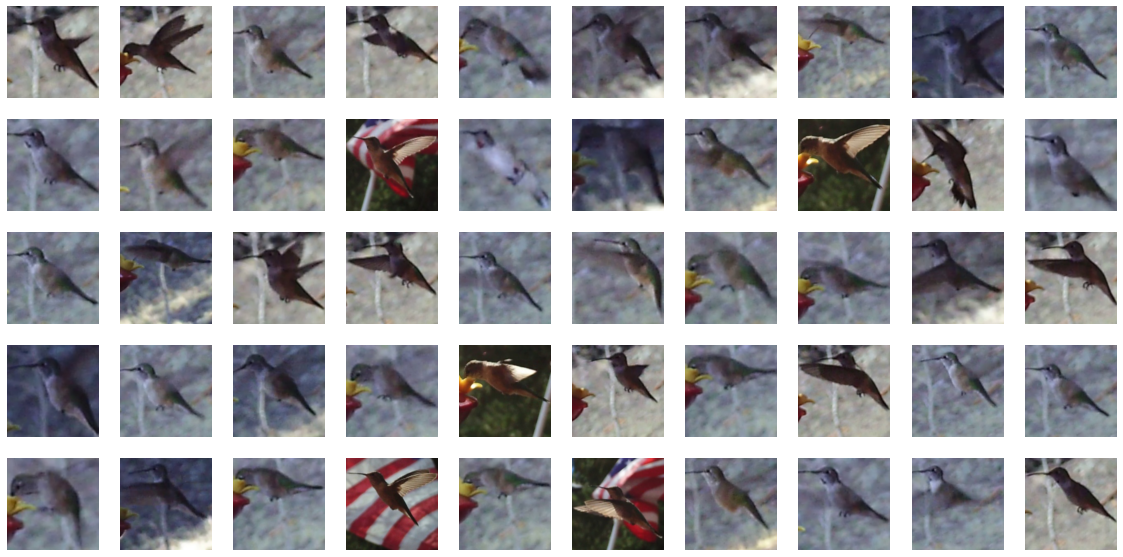

In [8]:
show_grid(lst_rufous_female, 5, 10, figsize = (20,10))

## Generate Data

In [9]:
generator = ImageDataGenerator(rescale = 1.0/255)

In [10]:
gen_train = generator.flow_from_directory(train_folder, 
                        target_size=(cfg.sshape[0],cfg.sshape[1]),  # target size
                        batch_size=32,                              # batch size
                        class_mode='categorical')    

gen_valid = generator.flow_from_directory(val_folder,
                        target_size=(cfg.sshape[0],cfg.sshape[1]),  # target size
                        batch_size=32,                              # batch size
                        class_mode='categorical')

gen_test = generator.flow_from_directory(test_folder,
                        target_size=(cfg.sshape[0],cfg.sshape[1]),  # target size
                        batch_size=32,                              # batch size
                        class_mode='categorical')

Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


# Building Model

In [11]:
# Two Convolution Layer CNN
model = Models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3,
                            padding="same", 
                            activation="relu", 
                            input_shape=cfg.sshape),    
    keras.layers.Conv2D(64, kernel_size=3, 
                            padding="same", 
                            activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(cfg.labels, activation="softmax")
])

# Show the Model Architecture
model.summary()

2022-05-08 14:07:43.176865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 14:07:43.268157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 14:07:43.269236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 160000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 160000)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               20480128  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

2022-05-08 14:07:43.271540: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-08 14:07:43.271904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 14:07:43.272890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 14:07:43.273802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## Evaluating matrics for call back

In [12]:
# Evaluation Metrics for Callback
def get_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def get_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_f1(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy',get_f1,get_precision,get_recall])

In [14]:
''' Callback option during training'''
callbacks = [ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=0, 
                               factor=0.5,mode='max',min_lr=0.001),
             ModelCheckpoint(filepath=f'model_cnn.h5',monitor='val_accuracy',
                             mode = 'max',verbose=0,save_best_only=True),
             TqdmCallback(verbose=0)] 

start = time.time()
history = model.fit(gen_train,
                    validation_data = gen_valid,
                    callbacks=callbacks,
                    verbose=0,
                    epochs=cfg.n_epochs  # Training for n_epoch interations
                   )
end = time.time()
print(f'The time taken to execute is {round(end-start,2)} seconds.')
print(f'Maximum Train/Val {max(history.history["accuracy"]):.4f}/{max(history.history["val_accuracy"]):.4f}')

0epoch [00:00, ?epoch/s]

2022-05-08 14:07:45.690647: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-08 14:07:47.404810: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


The time taken to execute is 60.99 seconds.
Maximum Train/Val 1.0000/0.8250


# Plot

In [15]:
''' FUNCTIONS FOR PLOTTING KERAS HISTORY RESULTS '''

# Function to plot all metrics side by side (defined above)
def plot_keras_metric(history):

    # Palettes
    lst_color = ['#B1D784','#2E8486','#004379','#032B52','#EAEA8A']
    metric_id = ['loss','get_f1','accuracy','get_precision','get_recall']
    fig = make_subplots(rows=1, cols=len(metric_id),subplot_titles=metric_id)

    jj=0;
    for metric in metric_id:     

        jj+=1

        # Main Trace
        fig.add_trace(go.Scatter(x=[i for i in range(1,cfg.n_epochs+1)],
                                 y=history.history[metric],
                                 name=f'train_{metric}',
                                 line=dict(color=lst_color[0]),mode='lines'),
                      row=1,col=jj)
        fig.add_trace(go.Scatter(x=[i for i in range(1,cfg.n_epochs+1)],
                                 y=history.history['val_'+metric],
                                 name=f'valid_{metric}',
                                 line=dict(color=lst_color[3]),mode='lines'),
                      row=1,col=jj)

        # difference between training/validation metrics
        if(metric is not 'loss'):
            diff = abs(np.array(history.history[metric]) - np.array(history.history['val_'+metric]))
            fig.add_trace(go.Bar(x=[i for i in range(1,cfg.n_epochs+1)],y=diff,name='metric diff.',
                                 text=diff.round(3),marker_color=lst_color[3],opacity=0.25,showlegend=False)
                          ,row=1,col=jj)

    fig.update_layout(yaxis=dict(range=[0,1]),yaxis_range=[0,1],
                      margin=dict(t=60,b=10),
                      height=300,showlegend=False,template='plotly_white',
                      hovermode="x",title=f'<b>CNN TRAINING</b>')
    fig['layout']['yaxis'].update(title='', range=[0,5], autorange=True,type='log')
    fig['layout']['yaxis2'].update(title='', range=[0, 1.1], autorange=False)
    fig['layout']['yaxis3'].update(title='', range=[0, 1.1], autorange=False)
    fig['layout']['yaxis4'].update(title='', range=[0, 1.1], autorange=False)
    fig['layout']['yaxis5'].update(title='', range=[0,1.1],autorange=False)
    fig.show()

In [16]:
plot_keras_metric(history)

# Augmentation

In [17]:
def plot_keras_metric2(lst_history,names):

    # Palettes
    lst_color = ['#B1D784','#2E8486','#004379','#032B52','#EAEA8A']
    metric_id = ['get_f1','acc','get_precision','get_recall']

    ii=-1
    for i in range(len(lst_history)):

        ii+=1; history = lst_history[ii]
        fig = make_subplots(rows=1, cols=4,subplot_titles=metric_id); jj=0
        for metric in metric_id:     

            jj+=1

            # Main Trace
            fig.add_trace(go.Scatter(x=[i for i in range(1,cfg.n_epochs+1)],y=history.history[metric],
                                     name=f'train_{metric}_{ii}',line=dict(color=lst_color[0]),mode='lines'),
                          row=1,col=jj)
            fig.add_trace(go.Scatter(x=[i for i in range(1,cfg.n_epochs+1)],y=history.history['val_'+metric],
                                     name=f'valid_{metric}_{ii}',line=dict(color=lst_color[3]),mode='lines'),
                          row=1,col=jj)

            # difference between training/validation metrics
            diff = abs(np.array(history.history[metric]) - np.array(history.history['val_'+metric]))
            
            fig.add_trace(go.Bar(x=[i for i in range(1,cfg.n_epochs+1)],y=diff,name='metric diff.',
                                 text=diff.round(3),marker_color=lst_color[2],opacity=0.25,showlegend=False)
                          ,row=1,col=jj)

            # Rest are for reference only
            for j in range(len(names)):
                if(j != ii):
                    lhistory = lst_history[j]
                    fig.add_trace(go.Scatter(x=[i for i in range(1,cfg.n_epochs+1)],y=lhistory.history[metric],
                                             name=f'train_{metric}_{j}',opacity=0.3,showlegend=False,
                                             line=dict(color='#D3D3D3'),mode='lines'),row=1, col=jj)
                    fig.add_trace(go.Scatter(x=[i for i in range(1,cfg.n_epochs+1)],y=lhistory.history['val_'+metric],
                                             name=f'val_{metric}_{j}',opacity=0.3,showlegend=False,
                                             line=dict(color='#D3D3D3'),mode='lines'),row=1, col=jj)

        if(len(names)>1):
            title=f"{' | '.join(str(x) for x in names[ii])}"
            if(type(names[0]) is not list):
                title= names[ii]
        else:
            title= f"{''.join(str(x) for x in names[ii])}"                    
                    
        fig.update_yaxes(tickvals=[i for i in np.arange(0.0,1.0,0.1)])
        fig.update_layout(yaxis=dict(range=[0,1]),yaxis_range=[0,1],
                          template='plotly_white',font=dict(family='sans-serif',size=14),
                          title=title,height=300,showlegend=False,
                          margin=dict(t=60,b=10)
                         )
            
        fig['layout']['yaxis1'].update(title='', range=[0,1], autorange=False, tick0=0, dtick=5)
        fig['layout']['yaxis2'].update(title='', range=[0,1], autorange=False, tick0=0, dtick=5)
        fig['layout']['yaxis3'].update(title='', range=[0,1], autorange=False, tick0=0, dtick=5)
        fig['layout']['yaxis4'].update(title='', range=[0,1], autorange=False, tick0=0, dtick=5)

        fig.add_hline(y=1.0,line_width=5)
        fig.show()

In [18]:
def augment_model(lst_aug):

    # Define DataGenerator, load image data from directory
    gen_train = lst_aug[0].flow_from_directory(train_folder, 
                            target_size=(cfg.sshape[0],cfg.sshape[1]),  # target size
                            batch_size=32,          # batch size
                            class_mode='categorical')    # batch size

    gen_valid = lst_aug[1].flow_from_directory(val_folder,
                            target_size=(cfg.sshape[0],cfg.sshape[1]),
                            batch_size=32,
                            class_mode='categorical')

    gen_test = lst_aug[1].flow_from_directory(test_folder,
                            target_size=(cfg.sshape[0],cfg.sshape[1]),
                            batch_size=32,
                            class_mode='categorical')

    # Define a CNN Model
    model = keras.models.Sequential([
        
        keras.layers.Conv2D(32, kernel_size=3, 
                                padding="same", 
                                activation="relu", 
                                input_shape=cfg.sshape),    
        keras.layers.Conv2D(64, 
                            kernel_size=3, 
                            padding="same", 
                            activation="relu"),
        
        keras.layers.MaxPool2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(cfg.labels, activation="softmax")
    ])
    
    # Compile Model
    model.compile(optimizer='Adam',
                  loss='categorical_crossentropy',
                  metrics=['acc',get_f1,get_precision,get_recall])
    
    # Callback Options During Training 
    callbacks = [ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=0, 
                                   factor=0.5,mode='max',min_lr=0.001),
                 ModelCheckpoint(filepath=f'model_out.h5',monitor='val_accuracy',
                                 mode = 'max',verbose=0,save_best_only=True),
                 TqdmCallback(verbose=0)] 
    
    # Evaluate Model
    history = model.fit(gen_train,
                        validation_data = gen_valid,
                        callbacks=callbacks,
                        verbose=0,epochs=cfg.n_epochs)
    
    # Return Result History
    return history 

In [19]:
# lst of augmentation options
lst_augopt = ['rescale','horizontal_flip','vertical_flip',
              'brightness_range','rotation_range','shear_range',
              'zoom_range','width_shift_range','height_shift_range',
              'channel_shift_range','zca_whitening','featurewise_center',
              'samplewise_center','featurewise_std_normalization','samplewise_std_normalization']

# lst of default setting corresponding to lst_augopt
lst_augval = [1.0/255,True,True,  
              [1.1,1.5],0.2,0.2,
              0.2,0,0,
              0,True,False,
             False,False,False]

# Get Augmentation Names from lst_select options
def get_aug_name(lst_select):
    lst_selectn = [];
    for i in lst_select:
        tlst_all = []
        for j in i:
            tlist_selectn = tlst_all.append(lst_augopt[j])
        lst_selectn.append(tlst_all)
    return lst_selectn

# Model Evaluation w/ Augmentation
def aug_eval(lst_select=None):

    ii=-1; lst_history = []
    for augs in lst_select:

        print('Augmentation Combination')
        # get dictionary of augmentation options
        ii+=1; dic_select = dict(zip([lst_augopt[i] for i in lst_select[ii]],[lst_augval[i] for i in lst_select[ii]]))
        print(dic_select)

        # define augmentation options
        train_datagen = ImageDataGenerator(**dic_select) # pass arguments
        gen_datagen = ImageDataGenerator(rescale=1.0/255)

        # evaluate model & return history metric
        history = augment_model([train_datagen,gen_datagen])

        # store results
        lst_history.append(history)
        
    return lst_history

In [20]:
lst_select = [[0,1],[0,2],[0,3],[0,1,5,6]] # list of augmentations
lst_selectn = get_aug_name(lst_select)     # get list of augmentation names
print(lst_selectn)

[['rescale', 'horizontal_flip'], ['rescale', 'vertical_flip'], ['rescale', 'brightness_range'], ['rescale', 'horizontal_flip', 'shear_range', 'zoom_range']]


In [21]:
# Evaluation Augmentation Models
history = aug_eval(lst_select)

Augmentation Combination
{'rescale': 0.00392156862745098, 'horizontal_flip': True}
Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


0epoch [00:00, ?epoch/s]

Augmentation Combination
{'rescale': 0.00392156862745098, 'vertical_flip': True}
Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


0epoch [00:00, ?epoch/s]

Augmentation Combination
{'rescale': 0.00392156862745098, 'brightness_range': [1.1, 1.5]}
Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


0epoch [00:00, ?epoch/s]

Augmentation Combination
{'rescale': 0.00392156862745098, 'horizontal_flip': True, 'shear_range': 0.2, 'zoom_range': 0.2}
Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


0epoch [00:00, ?epoch/s]

In [22]:
plot_keras_metric2(history,names=lst_selectn)

# Use in Pretrained Model

In [23]:
# Using the best augmentation combination
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  )
gen_datagen = ImageDataGenerator(rescale=1.0/255)

gen_train = train_datagen.flow_from_directory(train_folder, 
                        target_size=(cfg.sshape[0],cfg.sshape[1]),  # target size
                        batch_size=32,          # batch size
                        class_mode='categorical')    # batch size

gen_valid = gen_datagen.flow_from_directory(val_folder,
                        target_size=(cfg.sshape[0],cfg.sshape[1]),
                        batch_size=32,
                        class_mode='categorical')

gen_test = gen_datagen.flow_from_directory(test_folder,
                        target_size=(cfg.sshape[0],cfg.sshape[1]),
                        batch_size=32,
                        class_mode='categorical')

Found 400 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [24]:
# from tensorflow.keras import applications as app
def pretrained_model(head_id):

    # Define model with different applications
    model = Sequential()

    ''' Define Head Pretrained Models '''

    if(head_id is 'vgg'):
        model.add(app.VGG16(input_shape=cfg.sshape,
                            pooling='avg',
                            classes=1000,
                            include_top=False,
                            weights='imagenet'))

    elif(head_id is 'resnet'):
        model.add(app.ResNet101(include_top=False,
                               input_tensor=None,
                               input_shape=cfg.sshape,
                               pooling='avg',
                               classes=100,
                               weights='imagenet'))

    elif(head_id is 'mobilenet'):
        model.add(app.MobileNet(alpha=1.0,
                               depth_multiplier=1,
                               dropout=0.001,
                               include_top=False,
                               weights="imagenet",
                               input_tensor=None,
                               input_shape = cfg.sshape,
                               pooling=None,
                               classes=1000))

    elif(head_id is 'inception'):
        model.add(InceptionV3(input_shape = cfg.sshape, 
                                 include_top = False, 
                                 weights = 'imagenet'))

    elif(head_id is 'efficientnet'):
        model.add(EfficientNetB4(input_shape = cfg.sshape, 
                                    include_top = False, 
                                    weights = 'imagenet'))

    ''' Tail Model Part '''
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(cfg.labels,activation='softmax'))

    # # freeze main model coefficients
    model.layers[0].trainable = False
    model.compile(optimizer='Adam', 
                  loss='categorical_crossentropy',
                  metrics=['acc',get_f1,get_precision,get_recall])

    return model # return compiled model

In [25]:
# Pretraine Loaded Model 
def pretrain_eval(lst_heads,verbose=False):

    lst_history = []
    for head_id in lst_heads:

        # define CNN head model
        model = pretrained_model(head_id)

        ''' Callback Options During Training '''
        callbacks = [ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=0, 
                                       factor=0.5,mode='max',min_lr=0.001),
                     ModelCheckpoint(filepath=f'model_{head_id}.h5',monitor='val_acc',
                                     mode = 'max',verbose=0,save_best_only=True),
                     TqdmCallback(verbose=0)] 

        ''' Start Training '''
        start = time.time()
        history = model.fit(gen_train,
                            validation_data = gen_valid,
                            callbacks=callbacks,
                            verbose=0,
                            epochs=cfg.n_epochs)
        end = time.time()
        if(verbose):
            print(f'Head Model: {head_id}')
            print(f'The time taken to execute is {round(end-start,2)} seconds.')
            print(f'Maximum Train/Val {max(history.history["acc"]):.4f}/{max(history.history["val_acc"]):.4f}')

        lst_history.append(history)
        
    return lst_history

In [26]:
lst_heads = ['vgg','resnet','mobilenet','inception','efficientnet']
history = pretrain_eval(lst_heads)

58900480/58889256 [==============================] - 0s 0us/step


0epoch [00:00, ?epoch/s]

171458560/171446536 [==============================] - 1s 0us/step


0epoch [00:00, ?epoch/s]

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



17235968/17225924 [==============================] - 0s 0us/step


0epoch [00:00, ?epoch/s]

87924736/87910968 [==============================] - 1s 0us/step


0epoch [00:00, ?epoch/s]

71696384/71686520 [==============================] - 0s 0us/step


0epoch [00:00, ?epoch/s]

In [27]:
plot_keras_metric2(history,names=lst_heads)

In [28]:
for head_id in lst_heads:
    print(f'Head Model: {head_id}')
    
    # Load uncompiled model
    load_model = models.load_model(f"model_{head_id}.h5",compile=False)
    
    # Compile model
    load_model.compile(optimizer='Adam',
                       loss='categorical_crossentropy',
                       metrics=['acc',get_f1,get_precision,get_recall])
    
    # Evaluate on test dataset
    scores = load_model.evaluate(gen_test, verbose=1)

Head Model: vgg
3/3 [==============================] - 1s 94ms/step - loss: 0.2678 - acc: 0.9125 - get_f1: 0.9198 - get_precision: 0.9452 - get_recall: 0.8958
Head Model: resnet
3/3 [==============================] - 3s 56ms/step - loss: 1.0789 - acc: 0.6125 - get_f1: 0.2324 - get_precision: 0.8333 - get_recall: 0.1354
Head Model: mobilenet
3/3 [==============================] - 1s 59ms/step - loss: 0.6139 - acc: 0.8750 - get_f1: 0.8542 - get_precision: 0.8542 - get_recall: 0.8542
Head Model: inception
3/3 [==============================] - 2s 48ms/step - loss: 0.5443 - acc: 0.7750 - get_f1: 0.7849 - get_precision: 0.8111 - get_recall: 0.7604
Head Model: efficientnet
3/3 [==============================] - 4s 49ms/step - loss: 13.5587 - acc: 0.2500 - get_f1: 0.2604 - get_precision: 0.2604 - get_recall: 0.2604
